# Тестовое задание Строительный Двор

### Формулировка задачи

Дана выгрузка заказов с позициями.

  * Определить товары-"якоря"(основные) и дополнительные товары(сопутствующие).

  * Формат результата:

    * список основных и сопутствующих товаров по всей выборке;

    * список основных и сопутствующих товаров по каждому городу.
    
Данные даны как есть, без дополнительных пояснений. Интересны гипотезы, в рамках которых будет предложено решение.

### Гипотезы и допущения

Под основным товаром будем понимать первичные товары за которыми покупатель пришёл в магазин, основная цель, без которой посещение магазина станет, скорее всего, неоправданным. Для магазина такие товары предоставляют основную мотивацию для посещения клиентами, а также, значительную часть дохода.

  * Можно предположить, что основными товарами будут являться те, что чаще других встречаются как отдельные покупки (исходя из предположения что человек зашёл за конкретной вещью и взял только её), тем не менее, возможны ситуации когда покупатель проходил мимо магазина и зашёл за небольшим товаром явно сопутствующего характера (например, кончились диски для УШМ, по дороге зашёл и докупил). Данное предположение сильно зависит от возможности покупателя зайти в магазин дополнительно к другим целям, так, магазины формата отдельностоящего гипермаркета хорошо подходят под эту теорию (вряд ли клиент поедет в такой магазин только за сопутствующим товаром). Формат же супермаркета в комплексе с другими типами магазинов будут наоборот, способствовать таким спонтанным небольшим покупкам "по пути". Поскольку наши данные обезличены и мы не знаем типы магазинов, предположение о принадлежности к основным или дополнительным для чеков с 1 товаром будет неоправданным допущением.
  * Можно ожидать что основной товар будет иметь максимальную стоимость в чеке из нескольких позиций, т.к. это является прямым следствием заложенной в определение бизнес-логики. Для отбора основных товаров проанализируем чеки с более чем одной позицией и отберём из них самые дорогие товары.
  * Если возникнет необходимость сузить каталог основных товаров, можно будет дополнить условие отбора частотой с которой встречаются товары в чеках и/или стоимостным критерием.

Под сопутствующими товарами будем понимать товары которые не являются первичной целью похода в магазин, но могут быть комплиментарными к основному товару, дополнять его свойства, или быть необходимыми в процессе эксплуатации основного товара.

  * Предполагаемыми характеристиками являются небольшая цена (при высокой цене основного товара покупатель не будет испытывать угрызения о излишне потраченных средствах), относительно основного товара, наличие в разных комбинациях в чеках с основными товарами (частота появления в чеках).

### N.B.

В качестве метода решения данной задачи можно было бы попробовать создать корпус из чеков и пропустить его через CountVectorizer, добавить к векторам цены товаров и попробовать кластеризовать получившиеся данные. Поскольку у нас нет в наличии меток классов мерой успешности разделения можно было бы считать логическую обоснованность деления конкретных товаров на основные и сопутствующие, а также меру близости товаров внутри кластеров по характеристикам. Однако, предоставленная информация обезличенна и у нас нет в наличии каких-либо характеристик товаров, кроме цены и вхождения в различные чеки для оценки адекватности разбиения по кластерам. В связи с этим был исследован представленный ниже эвристический подход.

## EDA

Импортируем библиотеки.

In [1]:
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ydata_profiling import ProfileReport
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

Для удобства чтения данных будет отображать численные данные как целые числа.

In [2]:
pd.set_option('display.float_format', '{:0.3f}'.format)

Загрузим данные и сделаем первичный осмотр.

In [3]:
df = pd.read_csv('test_orders_info.csv', sep=';')

In [4]:
df.head()

,order_date,org,order_id,material,inv_qty,rev
0,20190801,1000,1009650752,3300030000,720.000,28080.000
1,20190801,1000,1009650752,7200859000,1.000,5037.000
2,20190801,1000,1009862550,7200859000,0.000,-2000.000
3,20190801,1000,1009924088,1500226000,864.000,165507.840
4,20190801,1000,1009924088,7200859000,2.000,24000.000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6051891 entries, 0 to 6051890
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   order_date  int64  
 1   org         int64  
 2   order_id    int64  
 3   material    int64  
 4   inv_qty     float64
 5   rev         float64
dtypes: float64(2), int64(4)
memory usage: 277.0 MB


In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
order_date,6051891.000,20192157.707,3041.305,20190801.000,20190908.000,20191018.000,20191205.000,20200131.000
org,6051891.000,1630.195,970.699,1000.000,1000.000,1000.000,2000.000,7000.000
order_id,6051891.000,2033077454.170,19203388.819,1008984447.000,2032632352.500,2033448118.000,2034243915.000,2035018963.000
material,6051891.000,3463417765.006,2416475923.603,20000.000,1000644000.000,3400913001.000,5500865000.000,9900999009.000
inv_qty,6051891.000,7.572,97.717,-6120.000,1.000,1.000,2.000,40608.000
rev,6051891.000,643.135,3418.305,-237517.200,60.300,150.000,380.000,1508000.000


Колонка `order_date`, очевидно, является датой заказа. Необходимо перевести в формат datetime.

Можно предположить что колонка `org` является меткой магазина в котором была совершена покупка, лучше перевести в категориальный тип, чтобы числовая ординальность не внесла искажения в работу алгоритмов.

Колонка `order_id`, предположительно, представляет собой уникальный 10ти значный id номер заказа/чека.

Можно предположить, что колонка `material` представляет собой уникальный id товара.

Колонка `inv_qty` может обозначать количество проданного товара. В данной колонке встречаются как целые (штуки), так и не целые (весовые товары) числа. Так же есть отрицательные значения, первичное предположение что они означают возврат товара, минус позволяет учесть возврат на складской запас. Необходимо уточнить в дальнейшём анализе.

Колонка `rev` может быть сокращением от revenue (доход), и обозначать как стоимость продажи одной единицы товара, так и всей позиции в чеке, необходимо уточнить в дальнейшем. Также есть отрицательные числа, возможно возвраты.

Пропусков в данных нет, проведём дополнительный анализ данных с помощью библиотеки `ydata_profile`.

In [7]:
df['order_date'] = pd.to_datetime(df['order_date'].astype('str'))
df['org'] = df['org'].astype('category')

In [8]:
profile = ProfileReport(df, title='Pandas Profiling Report')

In [9]:
profile.to_file('EDA_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

В полученном отчёте можно увидеть явную сезонность (зависимость продаж от даты), а также наличие средней корреляции между колонками `inv_qty` и `rev`, что может подтверждать наше предположение о том что цена указана не за единицу измерения, а за всю позицию целиком.

Попробуем проанализирорвать подробнее сезонность продаж.

<Axes: xlabel='order_date'>

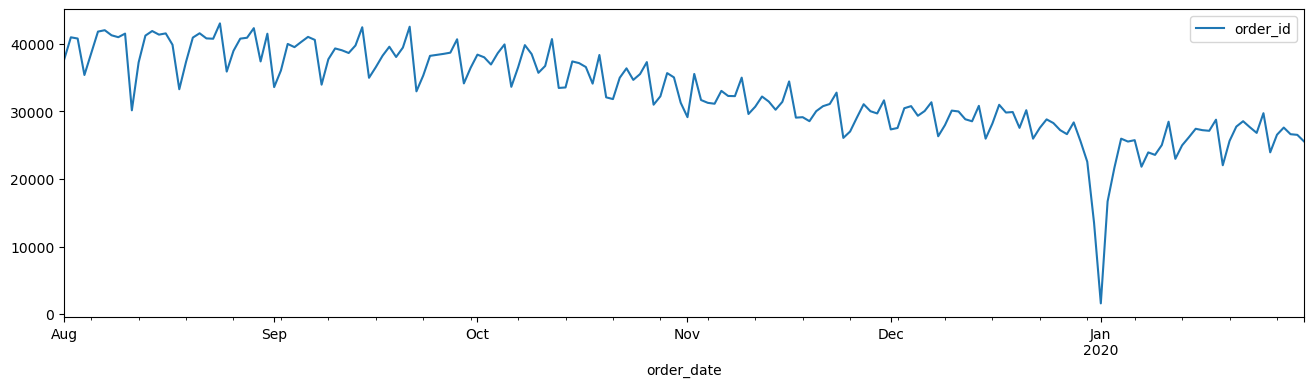

In [10]:
data = df[['order_date', 'order_id']].groupby('order_date').count()
plt.figure(figsize=(16, 4))
data.plot(ax=plt.gca())

Виден общий нисходящий тренд, можно разложить на компоненты тренда, сезонных явлений и остатков.

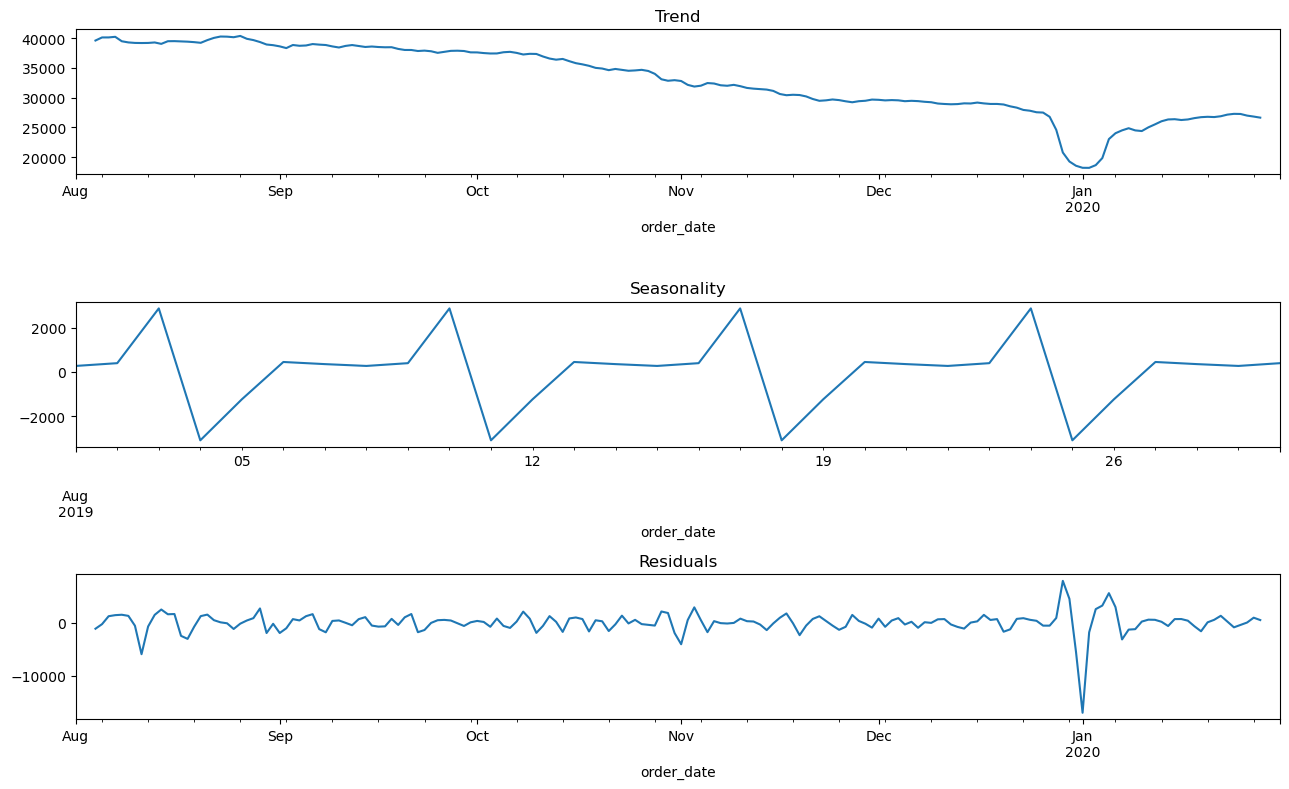

In [11]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(13, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.loc['2019-08-01':'2019-08-30'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

В остатках виден шум и резкое падение продаж на новый год.

В тренде есть выраженное падение продаж, вероятно, связанное с окончанием сезона активного строительства.

В сезонных колебаниях хорошо заметны пики продаж по субботам, провал по воскресеньям с постепенным возвращением в норму ко вторнику.

Проанализируем отрицательные значения в колонках с количеством товаров и ценами.

In [12]:
data = df.query('inv_qty <= 0 | rev < 0')
display(data.describe().transpose())
data.head()

,count,mean,min,25%,50%,75%,max,std
order_date,333,2019-10-08 01:39:27.567567616,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,NaN
order_id,333.000,2001378158.345,1008992355.000,2031120696.000,2032068562.000,2033026696.000,2034862158.000,174715140.633
material,333.000,3482853745.240,273001.000,900314001.000,3200153000.000,5900817001.000,9100879001.000,2635559533.664
inv_qty,333.000,-41.992,-6120.000,-2.000,-0.178,0.000,0.000,364.976
rev,333.000,-4273.826,-237517.200,-1376.000,-164.000,1.670,22017.600,20097.880


,order_date,org,order_id,material,inv_qty,rev
2,2019-08-01,1000,1009862550,7200859000,0.000,-2000.000
62,2019-08-01,1000,2030503854,100596000,-5.000,-2145.000
63,2019-08-01,1000,2030503854,100629000,-2.000,-1190.000
64,2019-08-01,1000,2030503854,300313000,-3.000,-4395.000
65,2019-08-01,1000,2030503854,600968000,-10.000,-2840.000


Всего 333 позиций, от 0 до -6120 по количеству и от 0 до -237517 по цене. Посмотрим на один из товаров в которых есть отрицательные значения.

In [13]:
df[df['material'] == 600968000].describe().transpose()

,count,mean,min,25%,50%,75%,max,std
order_date,6266,2019-10-25 14:41:47.245451776,2019-08-01 00:00:00,2019-09-10 00:00:00,2019-10-24 00:00:00,2019-12-07 18:00:00,2020-01-31 00:00:00,NaN
order_id,6266.000,2033481666.114,2030503854.000,2032670610.000,2033551534.500,2034284473.000,2035018112.000,939013.079
material,6266.000,600968000.000,600968000.000,600968000.000,600968000.000,600968000.000,600968000.000,0.000
inv_qty,6266.000,4.977,-10.000,1.000,2.000,5.000,480.000,12.032
rev,6266.000,1516.742,-2840.000,309.120,608.000,1416.800,129600.000,3656.018


Похоже, что первоначальное предположение оказалось верным. Столбец `inv_qty` отвечает за количество единиц товара в чеке, `rev` за общую сумму по данной позиции. Отрицательные значения, наиболее вероятно, означают возвраты. Количество их относительно общего незначительно и мы можем избавиться от этих данных, исходя из предположения что возвраты не повлияют на анализ основных и сопутствующих товаров.

In [14]:
df.drop(index=df[df['order_id'].isin(df.query('inv_qty <= 0 | rev < 0')['order_id'].unique())].index, inplace=True)
df.reset_index(drop=True, inplace=True)

Также интересен ряд товаров, с нулевой стоимостью, но неотрицательным количеством.

In [15]:
data = df.query('inv_qty > 0 & rev == 0')
data.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
order_date,19175,2019-10-23 02:28:50.628422400,2019-08-01 00:00:00,2019-09-08 00:00:00,2019-10-18 00:00:00,2019-12-06 00:00:00,2020-01-31 00:00:00,NaN
order_id,19175.000,2017580482.393,1008984447.000,2032580862.000,2033416965.000,2034244566.000,2035015372.000,126339036.805
material,19175.000,5727911091.246,54001.000,3300053000.000,7200859000.000,7200859000.000,9900999009.000,2212483508.215
inv_qty,19175.000,3.297,0.001,1.000,1.000,1.000,1386.790,26.677
rev,19175.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


Всего 19175 позиций, количеством от 0 до 1387. Посмотрим на самые частые значения.

In [16]:
data['material'].value_counts()

material
7200859000    12215
2700223000     1346
2100736000      753
2100828000      640
2500288003      447
              ...  
8300078000        1
2100504001        1
3800397000        1
2500714000        1
1100246000        1
Name: count, Length: 846, dtype: int64

Можно предположить, что товар `7200859000` это подарочная/скидочная карта, или же так проводится по базе карта постоянного покупателя. В целом, данный список можно считать первым приближением на сопутствующие товары, т.к. кроме подарочных карт, с большой долей вероятности, сюда попала всякая мелочовка и ходовые, но недорогие товары.

Заказы с бесплатными бонусами целесообразно оставить.

## Формирование списков товаров

### Основные товары

В соответствии с выбранной гипотезой, отберём основные товары, как товары с максимальной стоимостью в чеках, где больше одного товара.

Также зададимся частотой появления таких товаров в чеке, т.к. магазин тратится на место для раскладки и саму раскладку сопутствующих товаров вокруг основных. Для примера зададимся порогом в 10% наиболее часто встречающихся.

In [17]:
def get_main_list(data: pd.DataFrame = df, subset: int = None, threshold: int = 10) -> list:
    """
    Filters most expensive materials if there is more than one in bill and total appearance is more than threshold.
    """
    if subset:
        data = data[data['org'] == subset]
    counts = data.groupby('order_id').count()
    data = data[data['order_id'].isin(counts[counts['material'] > 1].index)]
    data = Counter(list(data.groupby('order_id').max('rev')['material']))
    threshold = np.quantile(list(data.values()), (100 - threshold) / 100)
    data = {material: count for material, count in data.items() if count >= threshold}
    most_expensive = list(data.keys())
    return most_expensive

In [18]:
main_list_full = get_main_list()
list_full = list(set(df['material']))

In [19]:
print('Количество товаров отнесённых к основным:', len(main_list_full))
print('Общее количество товаров доступных для анализа:', len(list_full))

Количество товаров отнесённых к основным: 1316
Общее количество товаров доступных для анализа: 21405


Также посмотрим на списки основных товаров по разным городам.

In [20]:
%%time
for city in list(df.org.unique()):
    globals()[f'main_list_{city}'] = get_main_list(subset=city)
    globals()[f'list_{city}'] = list(set(df[df['org'] == city]['material']))
    print(f'Количество товаров отнесённых к основным в городе {city}:', len(globals()[f'main_list_{city}']))
    print(f'Общее количество товаров доступных для анализа в городе {city}:', len(globals()[f'list_{city}']))
    print()

Количество товаров отнесённых к основным в городе 1000: 1115
Общее количество товаров доступных для анализа в городе 1000: 16857

Количество товаров отнесённых к основным в городе 2000: 787
Общее количество товаров доступных для анализа в городе 2000: 11889

Количество товаров отнесённых к основным в городе 3000: 701
Общее количество товаров доступных для анализа в городе 3000: 11365

Количество товаров отнесённых к основным в городе 4001: 442
Общее количество товаров доступных для анализа в городе 4001: 7202

Количество товаров отнесённых к основным в городе 7000: 72
Общее количество товаров доступных для анализа в городе 7000: 3973

CPU times: total: 3.28 s
Wall time: 3.3 s


Мы получили списки основных товаров для всех магазинов и для каждого в частности. В некоторых случаях в эти списки попало больше товаров, где-то только малая часть, в зависимости от общего размера ассортимента магазина. Чем больше в магазине представлено товаров в целом, тем больше в них часть основных. В среднем по всем данным у нас получилось что основными мы считаем 6,12% товаров.

### Сопутствующие товары

Как мы предположили в нашей гипотезе, мы будем искать товары которые не являются самыми дорогими в соответствующих чеках и попробуем отобрать самые часто встречающиеся из них. Зададимся попрогом в 5 сопутствующих товаров на каждый основной.

In [21]:
def get_acc_list(data: pd.DataFrame = df, subset: int = None,
                 main_list: list = main_list_full, N: int = 5) -> list:
    """
    For every main product find top N most frequent accompanying products and gather them to list.
    """
    if subset:
        data = data[data['org'] == subset]
        main_list = globals()[f'main_list_{subset}']
    result = set()
    for main_material in main_list:
        bill_list = list(data[data['material'] == main_material]['order_id'].unique())
        bill_data = data[data['order_id'].isin(bill_list)]
        bill_data = bill_data[~bill_data['material'].isin(main_list)]
        most_common = Counter(list(bill_data['material'])).most_common(N)
        most_common = set([_[0] for _ in most_common])
        result.update(most_common)
    return list(result)

In [22]:
%%time
acc_list_full = get_acc_list()
print('Количество товаров отнесённых к основным', len(main_list_full))
print('Количество товаров отнесённых к сопутствующим:', len(acc_list_full))
print('Общее количество товаров доступных для анализа:', len(list_full))

Количество товаров отнесённых к основным 1316
Количество товаров отнесённых к сопутствующим: 1274
Общее количество товаров доступных для анализа: 21405
CPU times: total: 1min 40s
Wall time: 1min 40s


Также посмотрим на списки товаров по отдельным городам.

In [23]:
%%time
for city in list(df.org.unique()):
    globals()[f'acc_list_{city}'] = get_acc_list(subset=city)
    print(f'Количество товаров отнесённых к основным в городе {city}:', len(globals()[f'main_list_{city}']))
    print(f'Количество товаров отнесённых к сопутствующим в городе {city}:', len(globals()[f'acc_list_{city}']))
    print(f'Общее количество товаров доступных для анализа в городе {city}:', len(globals()[f'list_{city}']))
    print()

Количество товаров отнесённых к основным в городе 1000: 1115
Количество товаров отнесённых к сопутствующим в городе 1000: 1185
Общее количество товаров доступных для анализа в городе 1000: 16857

Количество товаров отнесённых к основным в городе 2000: 787
Количество товаров отнесённых к сопутствующим в городе 2000: 891
Общее количество товаров доступных для анализа в городе 2000: 11889

Количество товаров отнесённых к основным в городе 3000: 701
Количество товаров отнесённых к сопутствующим в городе 3000: 760
Общее количество товаров доступных для анализа в городе 3000: 11365

Количество товаров отнесённых к основным в городе 4001: 442
Количество товаров отнесённых к сопутствующим в городе 4001: 723
Общее количество товаров доступных для анализа в городе 4001: 7202

Количество товаров отнесённых к основным в городе 7000: 72
Количество товаров отнесённых к сопутствующим в городе 7000: 151
Общее количество товаров доступных для анализа в городе 7000: 3973

CPU times: total: 1min 18s
Wall

## Заключение

В соответствии с изначальными гипотезами были сформированы списки наиболее вероятных основных и дополнительных товаров.

При необходимости полнота списков может быть отредактирована соответствующими настройками.